In [ ]:
# importação das bibliotecas necessárias

import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score
from tensorflow import keras

# Dataset

Fashion-MNIST é um conjunto de dados de imagens de roupas consistindo em um conjunto de treinamento de 60.000 exemplos e um conjunto de teste de 10.000 exemplos. Cada exemplo é uma imagem em tons de cinza 28x28, associada a um rótulo de 10 classes. Cada imagem tem 28 pixels de altura e 28 pixels de largura, totalizando 784 pixels. Cada pixel tem um único valor de pixel associado a ele, indicando a claridade ou escuridão desse pixel, com números mais altos significando mais escuro. Esse valor de pixel é um número inteiro entre 0 e 255. Os conjuntos de dados de treinamento e teste têm 785 colunas. A primeira coluna consiste nos rótulos de classe e representa o artigo de vestuário. O restante das colunas contém os valores de pixel da imagem associada.

# Carregamento dos dados

In [ ]:
#Importando o dataset
def load_dataset():


    train = pd.read_csv('/content/fashion-mnist_train.csv')
    test = pd.read_csv('/content/fashion-mnist_test.csv')


    # casting para deixar todos os valores no mesmo formato, float32
    # alguns métodos das bibliotecas utilizadas tem esse tipo como default
    train_data = np.array(train, dtype = 'float32')
    test_data = np.array(test, dtype='float32')

    # no dataset fashion-mnist a classe encontra-se na primeira label, sendo assim abaixo ela é separada para
    # definir as variáveis das classes.
    x_train = train_data[:,1:]

    y_train = train_data[:,0]

    x_test= test_data[:,1:]

    y_test=test_data[:,0]

    # normalizacao sera feita abaixo
    # a normalizacao vai reescalar dos tons de cinza para o intervalo de 0 e 1
    # cada pixel possui varia de 0 a 255, representando os tons de branco até cinza/preto
    # todos os valores foram divididos por 255 para normalizá-los no intervalo de 0 e 1
    x_train = x_train / 255.0

    x_test = x_test / 255.0

    # todas as imagens são no formato de 28x28 pixels, shape das imagens
    image_rows = 28
    image_cols = 28
    image_shape = (image_rows,image_cols,1)

    # estamos trabalhando com imagens de 28x28 pixels em tons de branco a cinza em diferentes escalas
    # tendo isso, essa imagem é tranposta em um único array
    x_train = x_train.reshape(x_train.shape[0],*image_shape)
    x_test = x_test.reshape(x_test.shape[0],*image_shape)

    # a classe possui 10 classes (0 a 9) representados por integers
    # com isso podemos transformá-lo em uma matriz binária de 10 elementos a partir do
    # método one hot encoding equivalente ao to_categorical da biblioteca keras aplicada
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return x_train, y_train, x_test, y_test

Abaixo iremos criar duas variáveis globais que utilizaremos ao longo do notebook:

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0) # instanciamento do LearningRateScheduler
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-'] # estilos de desenhos de linhas para os gráficos que serão construídos

A seguir será feito o carregamento dos dados:

In [ ]:
x_train, y_train, x_test, y_test = load_dataset()

# Definição do modelo base

In [ ]:
# Atendendo ao enunciado do EP a MLP que receberá os pixels da imagem é aproveitada a estrutura da CNN antes aplicada.
# Considera-se, para tanto, apenas a MLP utilizada para classificar os valores obtidos durante o processo de convolução e pooling

# Para definir o modelo chamamos "Sequential" um modelo de tensorflow.keras
# Esse é apropriado para utilização quando temos um tensor para cada entrada e saída em uma pilha simples de camada
# Dentre as formas de definir um modelo vamos optar pelo método (.add) empilhando a camada de forma incremental permitindo o monitoramento,
# observando-a como uma pilha de camadas, assim podemos observar a redução da resolução dos mapas de recurso da imagem
def define_basic_model():

	model = Sequential() # inicializa o modelo sequencial

	model.add(Flatten(input_shape=(28,28))) # a camada de entrada da MLP passa a ser a totalidade de pixels: 28 x 28 = 784 neurônios

	model.add(Dense(32, activation = 'relu', kernel_initializer='he_uniform')) # uma camada escondida com 32 neuronios

	model.add(Dense(10, activation='softmax'))
	# Por último, faremos aqui a camada de saída
	# Se tratando da camada de saída com filters=10 (quantidade de classes esperadas)
	# Altera-se a função de ativação de Relu para Softmax normalmente aplicada na última camada
	# Softmax() devolve um valor decimal de probabilidade para cada classe, Sftmax = exp(yi) / SUM{0-i}(exp(yi))


	model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
	# loss='categorical_crossentropy' foi escolhida pois é um método adequado quando se trabalha multi-classes
	return model

# Avaliação do modelo

In [ ]:
# Avaliação do modelo com cross validation, k=5
def evaluate_model(dataX, dataY, model, n_folds=5):
	scores, histories = list(), list()
	# Inicializa a função
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumera as partes
	for train_ix, test_ix in kfold.split(dataX):

		# seleciona os modelos de treino e teste
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# modela com a quantidade de épocas e o tamanho do batch
		history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=0)
		# Calcula a acurácia
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# alimenta a list de resposta
		scores.append(acc)
		histories.append(history)
	return scores, histories

# Impressão de resultados

In [ ]:
# Imprime o gráfico das curvas de apendizado
def summarize_diagnostics(histories):

	color = ['red', 'orange', 'yellow', 'green', 'blue'] # ordem das cores atribuidas a cada iteracao: vermelho para a primeira iteracao, laranja para a segunda, e assim por diante

	for i in range(len(histories)):
		# cuva de perdas
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color=color[i], label='train', linestyle=styles[i])
		pyplot.plot(histories[i].history['val_loss'], color=color[i], label='test', linestyle=styles[i])
		# curva de acurácia
		pyplot.subplot(212)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color=color[i], label='train', linestyle=styles[i])
		pyplot.plot(histories[i].history['val_accuracy'], color=color[i], label='test', linestyle=styles[i])
	pyplot.show()

In [ ]:
# Resume a performance do modelo
def summarize_performance(scores):
	# imprime os dados sumarizados
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# gráficos de caixa de resultados
	pyplot.boxplot(scores)
	pyplot.show()

# Juntando tudo

In [ ]:
# Executa o arnês de teste para avaliar um modelo
def run_test(model):

	# carregar conjunto de dados
	trainX, trainY, testX, testY = load_dataset()

	# avalia o modelo
	scores, histories = evaluate_model(trainX, trainY, model)

	# curvas de aprendizado
	summarize_diagnostics(histories)

	# resumir o desempenho estimado
	summarize_performance(scores)

# Avaliação do modelo base

> 87.692
> 89.783
> 89.825
> 90.358
> 91.750


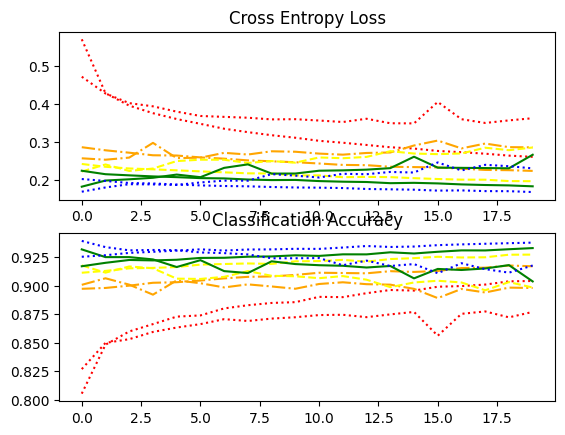

Accuracy: mean=89.882 std=1.306, n=5


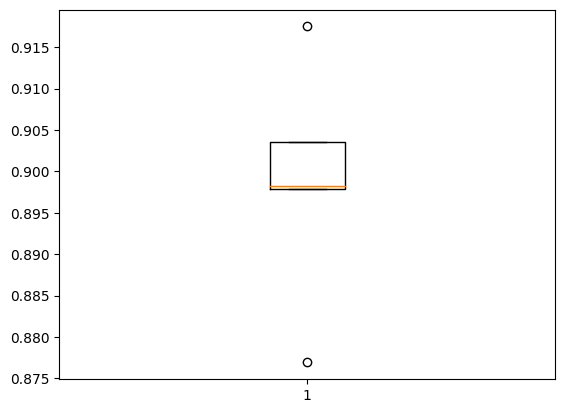

In [ ]:
run_test(define_basic_model())

# Calibração

Essa função possui como finalidade fazer a calibração do modelo, de forma a fazer testes com diferentes configurações para que seja escolhida a configuração que possuir o melhor desempenho, de modo a se levar em consideração também o custo computacional.

In [ ]:
# função que será utilizada para testar diferentes configurações de modelos
# Destaca-se que a função recebe um array<?> para identificar a quantidade de modelos a ser avaliados
# Ressalta-se que ao não executar e organizar esses modelos em um array model[] a função não terá retorno ou retornará o resultado de outro array model[]

def avalia_calibracao(names):

    nets = len(names) # numero de redes é equivalente aos nomes dados para cada configuracao de modelo

    # CRIAÇÃO DO CONJUNTO DE VALIDAÇÃO APLICANDO A CROSS VALIDATION
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(x_train, y_train, test_size = 0.333)

    k_folds = 3 # quantidade de folds

    history = [0] * nets * k_folds # quantidade de modelos totais que serao criados

    mean_val_hist = [] # lista que vai armazenar as acuracias medias de cada configuracao de modelo

    epochs = 20 # quantidade de epocas

    kfold = KFold(k_folds, shuffle=True, random_state=1)

    curr_model = -1 # numero do modelo atual, que na prática vai de 0 até [(nets * k_folds) - 1]

    for config_modelo in range(nets): # iteracao atraves de cada uma das configuracoes de modelos

        curr_mean_val = np.array([0.0] * epochs) # vetor que vai armazenar na posicao "x" a soma das (k_folds) acuracias da configuracao de modelo atual que tambem estao na posicao "x"

        # enumeracao dos k splits
        for train_ix, test_ix in kfold.split(X_train2):

            curr_model += 1 # numero do modelo atual que sera construido

            # select rows for train and test (validation)
            trainX, trainY, testX, testY = X_train2[train_ix], Y_train2[train_ix], X_train2[test_ix], Y_train2[test_ix]

            # treinamento da rede do modelo atual
            history[curr_model] = model[config_modelo].fit(trainX, trainY, batch_size=80, epochs = epochs, validation_data = (testX,testY), callbacks=[annealer], verbose=2)

            if ((curr_model + 1) % k_folds) == 0: # terminou de analisar todos os k folds para uma configuracao de modelo, agora é necessário escolher o melhor modelo da configuracao analisada entre os k modelos

                total_acc = [] # acuracias obtidas no treino
                total_acc_val = [] # acuracias obtidas na validacao

                for k in range(k_folds): # vamos voltar para analisar cada um dos modelos criados para a configuracao atual

                    total_acc += history[curr_model - k].history['accuracy'] # adiciona todas as acuracias (treinamento) do modelo atual na lista de acuracia da configuracao atual
                    total_acc_val += history[curr_model - k].history['val_accuracy'] # adiciona todas as acuracias (validacao) do modelo atual na lista de acuracia da configuracao atrual
                    curr_mean_val += np.array(history[curr_model - k].history['val_accuracy']) # incrementa com as metricas de cada modelo

                print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                  names[config_modelo],epochs,max(total_acc),max(total_acc_val)))

        curr_mean_val  = curr_mean_val / k_folds # divide para calcular a media
        curr_mean_val = list(curr_mean_val)
        mean_val_hist.append(curr_mean_val)

    # PLOT ACCURACIES
    plt.figure(figsize=(15,5))
    for i in range(nets):
        plt.plot(mean_val_hist[i],linestyle=styles[i])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    plt.show()

## Camadas e neurônios - em resposta ao item A do EP

In [ ]:
# Construção das redes neurais que serão comparadas com 1 ou 3 camadas e com diferentes quantidades de neurônios

nets = 4 # quantidade de redes
model = [0] *nets # modelos que serão construidos

for j in range(nets):

    model[j] = Sequential()
    model[j].add(Flatten(input_shape=(28,28)))

    if j < 2: # dois primeiros modelos com 128 neuronios
      model[j].add(Dense(128, activation = 'relu', input_shape=(28*28,), kernel_initializer='he_uniform')) # primeira camada


      if j == 1: # modelo com 3 camadas
        model[j].add(Dense(128, activation = 'relu', kernel_initializer='he_uniform')) # segunda camada
        model[j].add(Dense(128, activation = 'relu', kernel_initializer='he_uniform')) # terceira camada

    else: # dois ultimos modelos com 512 neuronios

      model[j].add(Dense(512, activation = 'relu', input_shape=(28*28,), kernel_initializer='he_uniform')) # primeira camada

      if j == (nets-1): # ultimo modelo com 3 camadas
        model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # segunda camada
        model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # teceira camada

    model[j].add(Dense(10, activation = 'softmax')) # camada de saida

    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/20
334/334 - 2s - loss: 0.6272 - accuracy: 0.7840 - val_loss: 0.4676 - val_accuracy: 0.8383 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 2/20
334/334 - 1s - loss: 0.4466 - accuracy: 0.8450 - val_loss: 0.4564 - val_accuracy: 0.8395 - lr: 9.5000e-04 - 1s/epoch - 4ms/step
Epoch 3/20
334/334 - 2s - loss: 0.4063 - accuracy: 0.8576 - val_loss: 0.4135 - val_accuracy: 0.8494 - lr: 9.0250e-04 - 2s/epoch - 4ms/step
Epoch 4/20
334/334 - 2s - loss: 0.3754 - accuracy: 0.8674 - val_loss: 0.4175 - val_accuracy: 0.8513 - lr: 8.5737e-04 - 2s/epoch - 5ms/step
Epoch 5/20
334/334 - 1s - loss: 0.3467 - accuracy: 0.8776 - val_loss: 0.3737 - val_accuracy: 0.8663 - lr: 8.1451e-04 - 1s/epoch - 3ms/step
Epoch 6/20
334/334 - 1s - loss: 0.3321 - accuracy: 0.8837 - val_loss: 0.3948 - val_accuracy: 0.8560 - lr: 7.7378e-04 - 1s/epoch - 4ms/step
Epoch 7/20
334/334 - 2s - loss: 0.3173 - accuracy: 0.8883 - val_loss: 0.3611 - val_accuracy: 0.8702 - lr: 7.3509e-04 - 2s/epoch - 5ms/step
Epoch 8/20
334/334 - 1s - loss:

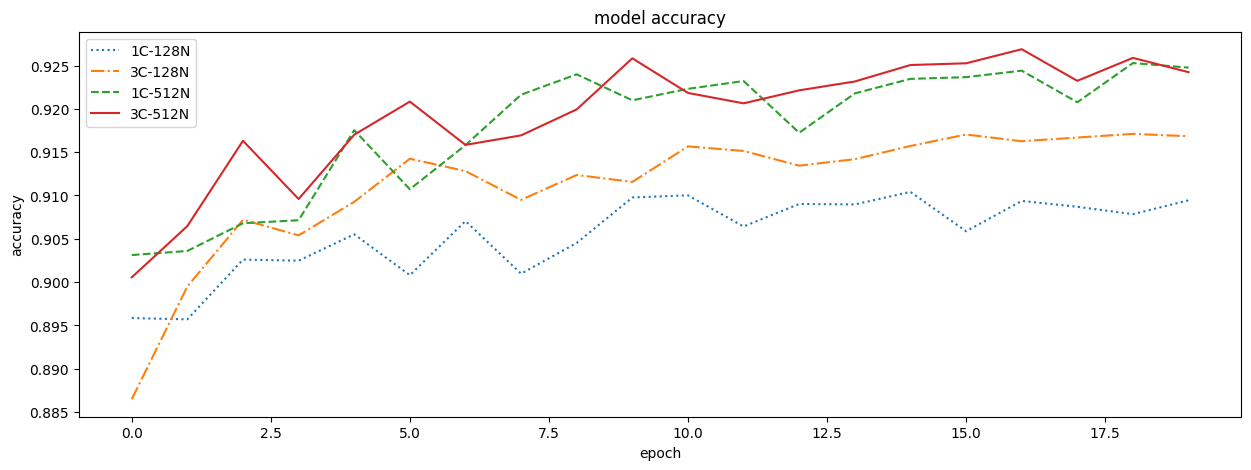

In [ ]:
names = ["1C-128N","3C-128N","1C-512N", "3C-512N"]
avalia_calibracao(names)

A partir do gráfico acima, infere-se que a utilização de 3 camadas com 512 neurônios apresenta uma melhor performance.

## Regularização L2 - em resposta ao item B do EP

Ao implementar a MLP, durante o processo de ajuste dos pesos, a cada iteração quando os pesos são atualizados pelo método gradient descent para generalizar as relações corretas para um modelo de predição um dos problemas durante o treinamento de um modelo é o overfitting, sendo o modelo de treino memorizado fazendo com que a classificação apresente uma acurácia satisfatória apenas na base de treino enquanto na de teste apresenta resultados descolados frente ao esperado pelo alcançado durante o treino. As técnicas de regularização buscam evitar esse overfitting.

Para este trabalho será apresentado a regularização aplicando o método L2, que consiste na soma quadrática dos resíduos adicionado ao quadrado dos pesos + lambda (taxa de penalidade). Em um cenário em que a quantidade de variáveis de entrada excedem as observações o método evita a criação de um modelo com grandes intervalos de previsão onde um estimador de mínimos quadrados pode deixar de existir exclusivamente.

Source: https://neuraspike.com/blog/l2-regularization-with-python/

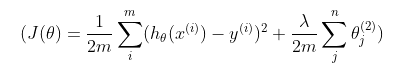

Para melhor explicação a função é dividida em parte 1 :  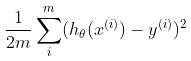  e parte 2 :  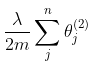

Na parte 1 é calculado o custo/loss médio sob todo o dataset de treino (soma dos quadrados dos residuos). Em seguida, na parte 2 é calculado o termo de penalidade de regularização, incluindo o lambda e o quadrado do slope (inclinação).

A parte 2 da função adiciona uma penalidade ao custo/loss enquanto o lambda determina o quão efetiva ela será.

Ao determinar o lambda deve-se ter o cuidado entender a mecânica dessa variável. Ao escolher um valor muito alto para o lambda a penalidade pode perder a sensibilidade e ao optar por um valor mais baixo com penalidade reduzida e melhora no overfit dos dados de treino. No momento zero apenas a parte 1 é minimizada enquanto a parte 2 é excluída.

Um procedimento sugerido para encontrar o valor ideal para o lambda é testar diferentes valores com o método de cross-validation.

Abaixo um exemplo de como diferentes valores de lambda podem descolar de um valor central.

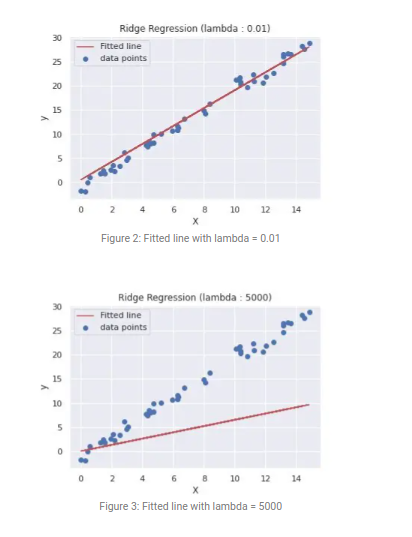

Tomando a derivada da função de custo regularizada em relação aos pesos, obtemos:

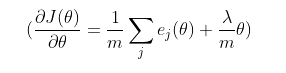

KERAS : parte-se inicialmente da classe kernel_regularizer que aplica a penalidade na camada do kernel. Essa classe disponibiliza os métodos L1, L2, L1L2 (combinação dos dois anteriores) e OrthogonalRegularizer que para os fins deste trabalho será detalhado apenas o método L2 que foi solicitação aplicação.

Sendo : loss = l2 * reduce_sum(square(x)), onde l2 por padrão é 0.01 podendo ser passado como parâmetro a escolha do usuário.


De forma resumida: a regularização tem como objetivo diminuir os pesos da rede. Essa técnica faz isso através da adição dos pesos na função de loss, de modo a penalizar modelos com altos pesos.

A Regularização L2 faz isso através da adição da soma dos erros quadrados na função loss, de modo a penalizar severamente pesos com altos valores.

In [ ]:
# Construção das redes neurais que serão comparadas
# Serão comparadas 4 configurações de modelos, cada uma com as seguintes taxas de regularização {0.0, 0.01, 0.02, 0.03}

nets = 4
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()
    model[j].add(Flatten(input_shape=(28,28)))

    if j == 0: # modelo sem regularizacao
      model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # primeira camada
      model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # segunda camada
      model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # teceira camada

    else:
      model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(0.01 * j))) # primeira camada
      model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(0.01 * j))) # segunda camada
      model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(0.01 * j))) # teceira camada

    model[j].add(Dense(10, activation='softmax')) # camada de saida

    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/20
334/334 - 4s - loss: 0.5480 - accuracy: 0.8010 - val_loss: 0.4612 - val_accuracy: 0.8328 - lr: 0.0010 - 4s/epoch - 12ms/step
Epoch 2/20
334/334 - 2s - loss: 0.3910 - accuracy: 0.8556 - val_loss: 0.4147 - val_accuracy: 0.8504 - lr: 9.5000e-04 - 2s/epoch - 5ms/step
Epoch 3/20
334/334 - 2s - loss: 0.3511 - accuracy: 0.8689 - val_loss: 0.3994 - val_accuracy: 0.8539 - lr: 9.0250e-04 - 2s/epoch - 6ms/step
Epoch 4/20
334/334 - 2s - loss: 0.3263 - accuracy: 0.8799 - val_loss: 0.3865 - val_accuracy: 0.8597 - lr: 8.5737e-04 - 2s/epoch - 5ms/step
Epoch 5/20
334/334 - 2s - loss: 0.2954 - accuracy: 0.8889 - val_loss: 0.3557 - val_accuracy: 0.8774 - lr: 8.1451e-04 - 2s/epoch - 5ms/step
Epoch 6/20
334/334 - 1s - loss: 0.2769 - accuracy: 0.8955 - val_loss: 0.3642 - val_accuracy: 0.8707 - lr: 7.7378e-04 - 1s/epoch - 4ms/step
Epoch 7/20
334/334 - 2s - loss: 0.2652 - accuracy: 0.9010 - val_loss: 0.3422 - val_accuracy: 0.8771 - lr: 7.3509e-04 - 2s/epoch - 5ms/step
Epoch 8/20
334/334 - 2s - loss

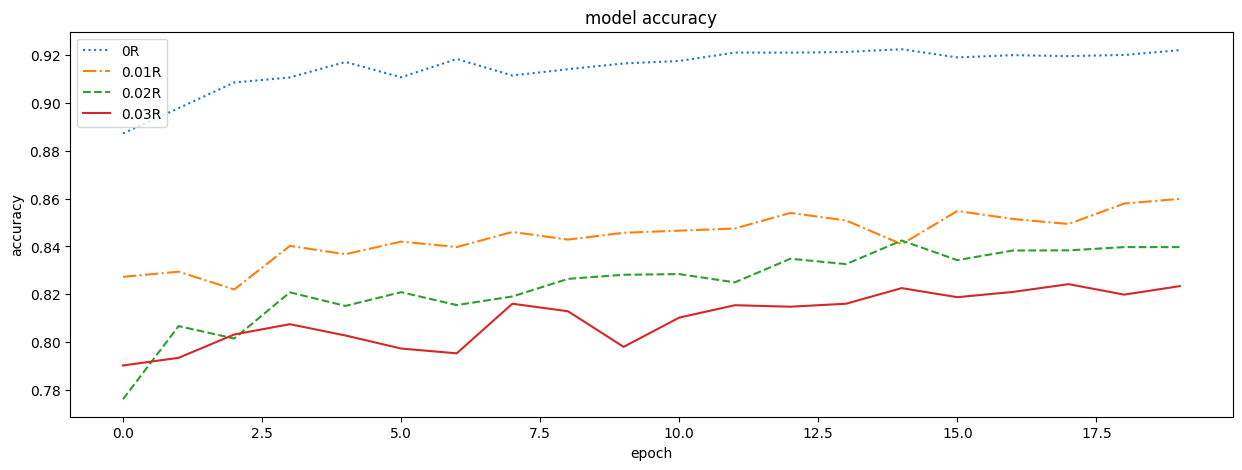

In [ ]:
names = ["0R","0.01R","0.02R","0.03R"]
avalia_calibracao(names)

A partir do gráfico acima, conclui-se que a aplicação da regularização não resultou na melhora do desempenho. Portanto, sua implementação será não utilizada.

## Droupout - em resposta ao item C do EP

Conceituação - https://www.deeplearningbook.com.br/capitulo-23-como-funciona-o-dropout/

O dropout é uma técnica de regularização amplamente empregada no treinamento de redes neurais, ele tem como propósito evitar o overfitting no modelo, isto é, ele evita o fenômeno no qual o modelo se ajusta excessivamente aos dados de treinamento, a fim de gerar melhores generalização para novos dados.
Durante o treinamento com dropout, neurônios das camadas ocultas são selecionadas aleatoriamente e temporariamente inativados, implicando na remoção temporária de suas contribuições para a propagação de sinais e atualização de pesos.

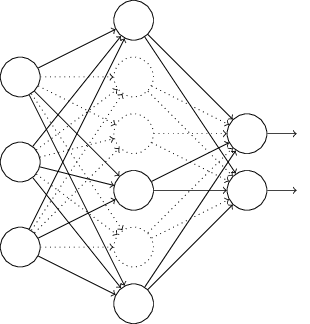

Essa abordagem auxilia na redução da coadaptação entre neurônios, incentivando a rede neural a aprender características mais robustas e independentes dos dados de treinamento.



O dropout permite que ao criarmos várias redes diferentes por exclusão de alguns neurônios fazer um processo similar e menos custosa e o resultado também será variável podendo ser ou não melhor como dependerá da quantidade e redes formadas.

Vale ressaltar que no dropout como há a redução de participação de neurônios, os mais ativos são obrigados a se adaptar com mais esforço uma vez que o resultado passa a depender mais deles trazendo maior robustez a técnica.


In [ ]:
# Construção das redes neurais convolucionais que serão comparadas
# Serão comparadas 3 configurações testando o aprendizado até a ausência de metade dos neurônios, {0.0, 0.25, 0.5}.

nets = 3
model = [0] *nets

for j in range(nets): # o modelo j vai ter um dropout de (j*0.25)% ao final de cada camada
    model[j] = Sequential()
    model[j].add(Flatten(input_shape=(28,28)))

    model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # primeira camada
    model[j].add(Dropout(j*0.25))

    model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # segunda camada
    model[j].add(Dropout(j*0.25))

    model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # terceira camada
    model[j].add(Dropout(j*0.25))

    model[j].add(Dense(10, activation='softmax')) # camada de saida

    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/20
334/334 - 4s - loss: 0.5581 - accuracy: 0.7992 - val_loss: 0.4146 - val_accuracy: 0.8507 - lr: 0.0010 - 4s/epoch - 12ms/step
Epoch 2/20
334/334 - 2s - loss: 0.3929 - accuracy: 0.8540 - val_loss: 0.4093 - val_accuracy: 0.8511 - lr: 9.5000e-04 - 2s/epoch - 5ms/step
Epoch 3/20
334/334 - 2s - loss: 0.3490 - accuracy: 0.8713 - val_loss: 0.3876 - val_accuracy: 0.8598 - lr: 9.0250e-04 - 2s/epoch - 5ms/step
Epoch 4/20
334/334 - 1s - loss: 0.3168 - accuracy: 0.8835 - val_loss: 0.3460 - val_accuracy: 0.8786 - lr: 8.5737e-04 - 1s/epoch - 4ms/step
Epoch 5/20
334/334 - 2s - loss: 0.2979 - accuracy: 0.8885 - val_loss: 0.3944 - val_accuracy: 0.8567 - lr: 8.1451e-04 - 2s/epoch - 5ms/step
Epoch 6/20
334/334 - 1s - loss: 0.2769 - accuracy: 0.8960 - val_loss: 0.3646 - val_accuracy: 0.8734 - lr: 7.7378e-04 - 1s/epoch - 4ms/step
Epoch 7/20
334/334 - 1s - loss: 0.2536 - accuracy: 0.9024 - val_loss: 0.3305 - val_accuracy: 0.8807 - lr: 7.3509e-04 - 1s/epoch - 4ms/step
Epoch 8/20
334/334 - 2s - loss

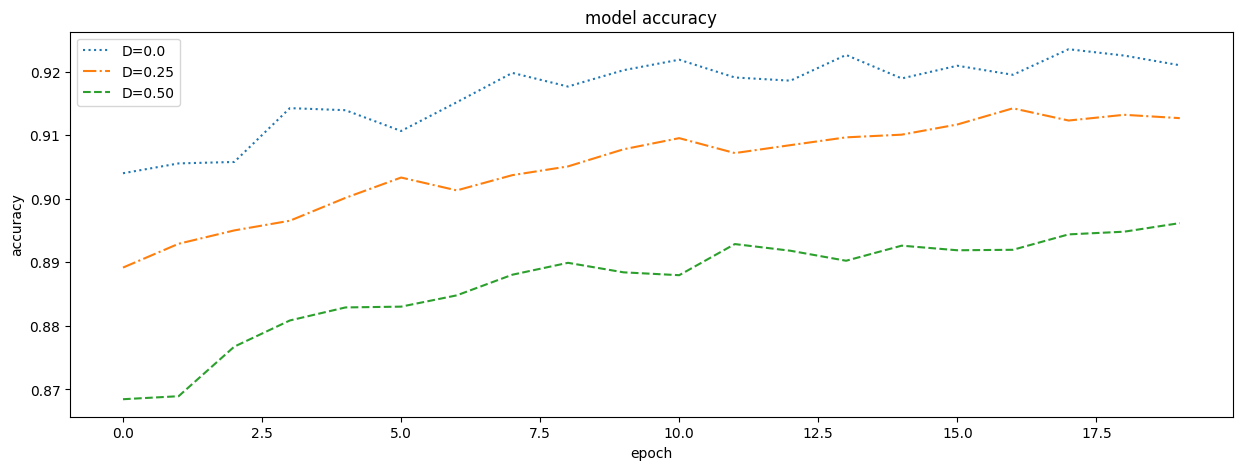

In [ ]:
names = ["D=0.0","D=0.25","D=0.50"]
avalia_calibracao(names)

A partir do gráfico acima, infere-se que a porcentagem de dropout que obteve o melhor desempenho foi 0%, ou seja, a não utilização do dropout foi o que resultou em um melhor desempenho.

## Data Augmentation - em resposta ao item D do EP

Data augmentation é uma prática empregada com o intuito de ampliar o tamanho e a diversidade do conjunto de dados de treinamento para resultar em um melhor desempenho do modelo.
Utilizando dos dados de treinamento, ele aplica transformações aleatórias aos dados existentes, gerando exemplos adicionais que possuem semelhanças, mas também diferem dos exemplos originais.

Alguns exemplos de tranformações que são possíveis de obter atráves do Data Augmentation são: rotação, espelhamento, translação, zoom, ajuste de brilho e outros.
Ao introduzir essas transformações, aumenta-se a variabilidade dos dados de treinamento, possibilitando que o modelo generalize mais eficazmente para diferentes condições e variações encontradas nos dados de teste.

In [ ]:
# Construção das redes neurais convolucionais que serão comparadas
# Será comparado duas configurações de modelos, em que o primeiro não utiliza a ténica Data Augmentation
# e a segunda a implementa

nets = 2
model = [0] *nets

# modelo basico
j=0
model[j] = Sequential()
model[j].add(Flatten(input_shape=(28,28)))
model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # primeira camada
model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # segunda camada
model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # teceira camada
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# modelo para data augmentation
j=1
model[j] = Sequential()
model[j].add(Flatten(input_shape=(28,28)))
model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # primeira camada
model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # segunda camada
model[j].add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # teceira camada
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Para fazer a comparação dos dois modelos, foi necessário fazer alterações na função de calibração original. Sendo assim, foi criada a seguinte função que testa e compara 2 configurações de modelos, em que o primeiro não implementa o Data Augmentation, enquanto o segundo implementa:

In [ ]:
def avalia_calibracao_data_aug(names):


    nets = 2 # numero de redes é equivalente aos nomes dados para cada tipo de rede

    # CRIAÇÃO DO CONJUNTO DE VALIDAÇÃO APLICANDO A CROSS VALIDATION

    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(x_train, y_train, test_size = 0.333)

    k_folds = 3 # quantidade de folds

    history = [0] * nets * k_folds # quantidade de modelos que serao criados

    mean_val_hist = [] # lista que vai armazenar as acuracias medias de cada epoca de um determinada configuracao de modelo

    epochs = 10 # quantidade de epocas

    kfold = KFold(k_folds, shuffle=True, random_state=1)

    curr_model = -1 # numero do modelo atual, que vai de 0 até [(nets * k_folds) - 1]

    # ----------------------- avaliacao do modelo basico -------------------------

    for config_modelo in range(nets - 1): # iteracao atraves de cada uma das j configuracoes de modelos


        curr_mean_val = np.array([0.0] * epochs) # vetor que vai armazenar na posicao "x" a soma das (k_folds) acuracias da configuracao (j) que tambem estao na posicao "x"

      # enumeracao dos k splits
        for train_ix, test_ix in kfold.split(X_train2):

            curr_model += 1 # numero do modelo atual que sera construido

          # select rows for train and test (validation)
            trainX, trainY, testX, testY = X_train2[train_ix], Y_train2[train_ix], X_train2[test_ix], Y_train2[test_ix]

          # treinamento da rede do modelo atual
            history[curr_model] = model[config_modelo].fit(trainX, trainY, batch_size=80, epochs = epochs, validation_data = (testX,testY), callbacks=[annealer], verbose=2)

            if ((curr_model + 1) % k_folds) == 0: # terminou de analisar todos os k folds para uma configuracao de modelo, agora é necessário escolher o melhor modelo da configuracao analisada entre os k modelos

                total_acc = [] # acuracias obtidas no treino
                total_acc_val = [] # acuracias obtidas na validacao

                for k in range(k_folds): # vamos voltar para analisar cada um dos modelos criados para a configuracao atual

                    total_acc += history[curr_model - k].history['accuracy'] # adiciona todas as acuracias (treinamento) do modelo atual na lista de acuracia da configuracao atual
                    total_acc_val += history[curr_model - k].history['val_accuracy'] # adiciona todas as acuracias (validacao) do modelo atual na lista de acuracia da configuracao atrual
                    curr_mean_val += np.array(history[curr_model - k].history['val_accuracy']) # incrementa com as metricas de cada modelo

                print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                  names[config_modelo],epochs,max(total_acc),max(total_acc_val)))

        curr_mean_val  = curr_mean_val / k_folds # divide para calcular a media
        curr_mean_val = list(curr_mean_val)
        mean_val_hist.append(curr_mean_val)


    # ----------------------- avaliacao do modelo com data augmentation -------------------------

    # CREATE MORE TRAINING IMAGES VIA DATA AUGMENTATION
    datagen = ImageDataGenerator(
            rotation_range=10, # faixa de graus para rotações aleatórias
            zoom_range = 0.1,  # faixa para zoom aleatório
            width_shift_range=0.1, # fração da largura total
            height_shift_range=0.1) # fração da altura total

    # CRIAÇÃO DO CONJUNTO DE VALIDAÇÃO APLICANDO A CROSS VALIDATION
    config_modelo = 1 # configuracao de modelo 1 se refere a configuracao que aplica o data augmentation

    curr_mean_val = np.array([0.0] * epochs)

    curr_model = 2 # iremos avaliar o modelo de posicao 3 (os modelos 0, 1 e 2 nao aplicam o data augmentation)

    # lembrando que ao entrar no seguinte for loop, curr_model é incrementado em 1 unidade, por isso ele não assume
    # o valor 3 na linha acima

    # enumeracao dos k splits
    for train_ix, test_ix in kfold.split(X_train2):

        curr_model += 1 # numero do modelo atual que sera construido

        # select rows for train and test (validation)
        trainX, trainY, testX, testY = X_train2[train_ix], Y_train2[train_ix], X_train2[test_ix], Y_train2[test_ix]

        # treinamento da rede do modelo atual
        history[curr_model] = model[j].fit(datagen.flow(trainX,trainY, batch_size=64),
        epochs = epochs, steps_per_epoch = trainX.shape[0]//64,
        validation_data = (testX,testY), callbacks=[annealer], verbose=2)


        if ((curr_model + 1) % k_folds) == 0: # terminou de analisar todos os k folds para uma configuracao de modelo, agora é necessário escolher o melhor modelo da configuracao analisada entre os k modelos

            total_acc = [] # acuracias obtidas no treino
            total_acc_val = [] # acuracias obtidas na validacao

            for k in range(k_folds): # vamos voltar para analisar cada um dos modelos criados para a configuracao atual

                total_acc += history[curr_model - k].history['accuracy'] # adiciona todas as acuracias (treinamento) do modelo atual na lista de acuracia da configuracao atual
                total_acc_val += history[curr_model - k].history['val_accuracy'] # adiciona todas as acuracias (validacao) do modelo atual na lista de acuracia da configuracao atrual
                curr_mean_val += np.array(history[curr_model - k].history['val_accuracy']) # incrementa com as metricas de cada modelo

            print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                names[j],epochs,max(total_acc),max(total_acc_val)))

    curr_mean_val  = curr_mean_val / k_folds # divide para calcular a media
    curr_mean_val = list(curr_mean_val)
    mean_val_hist.append(curr_mean_val)

    # PLOT ACCURACIES
    plt.figure(figsize=(15,5))
    for i in range(nets):
        plt.plot(mean_val_hist[i],linestyle=styles[i])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    plt.show()

Por fim, a função criada acima será utilizada:

Epoch 1/10
334/334 - 3s - loss: 0.5439 - accuracy: 0.8000 - val_loss: 0.4024 - val_accuracy: 0.8534 - lr: 0.0010 - 3s/epoch - 10ms/step
Epoch 2/10
334/334 - 2s - loss: 0.3960 - accuracy: 0.8548 - val_loss: 0.3825 - val_accuracy: 0.8625 - lr: 9.5000e-04 - 2s/epoch - 5ms/step
Epoch 3/10
334/334 - 2s - loss: 0.3490 - accuracy: 0.8686 - val_loss: 0.3698 - val_accuracy: 0.8672 - lr: 9.0250e-04 - 2s/epoch - 5ms/step
Epoch 4/10
334/334 - 1s - loss: 0.3180 - accuracy: 0.8802 - val_loss: 0.3422 - val_accuracy: 0.8763 - lr: 8.5737e-04 - 1s/epoch - 4ms/step
Epoch 5/10
334/334 - 1s - loss: 0.2913 - accuracy: 0.8906 - val_loss: 0.3705 - val_accuracy: 0.8693 - lr: 8.1451e-04 - 1s/epoch - 4ms/step
Epoch 6/10
334/334 - 1s - loss: 0.2749 - accuracy: 0.8963 - val_loss: 0.3341 - val_accuracy: 0.8805 - lr: 7.7378e-04 - 1s/epoch - 4ms/step
Epoch 7/10
334/334 - 1s - loss: 0.2561 - accuracy: 0.9025 - val_loss: 0.3330 - val_accuracy: 0.8844 - lr: 7.3509e-04 - 1s/epoch - 4ms/step
Epoch 8/10
334/334 - 1s - loss

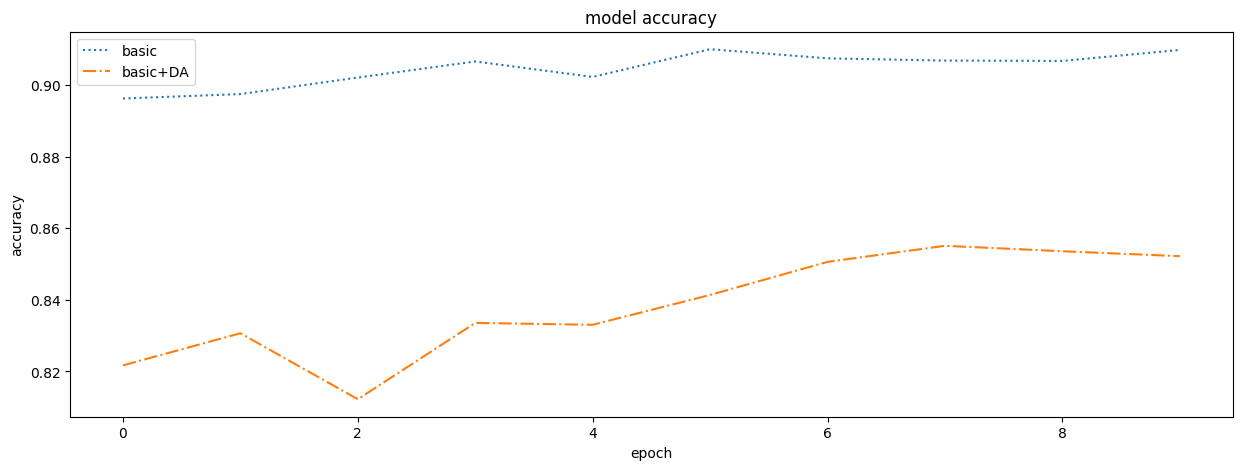

In [ ]:
names = ["basic","basic+DA"]
avalia_calibracao_data_aug(names)

A partir do gráfico acima, infere-se que o uso da técnica Data Augmentation resultou em um desempenho inferior em comparação com o modelo base. Portanto, essa técnica não será utilizada para a construção do modelo final.

# Comparação do modelo base com modelo final

Nesta seção será comparado o desempenho do modelo base (inicial) em comparação com o modelo final, que foi obtido a partir dos testes de calibração feitos até então. Como função que instancia o modelo base já foi criada (define_basic_model), será criada uma função que instancia uma configuração do modelo final:

In [ ]:
def define_final_model():

  model = Sequential()
  model.add(Flatten(input_shape=(28,28)))
  model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # primeira camada
  model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # segunda camada
  model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform')) # teceira camada
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

Agora será feito a comparação entre os 2 modelos: o modelo base (inicial) e o modelo final (criado após a calibração).

In [ ]:
model = [0] * 2
model[0] = define_basic_model()
model[1] = define_final_model()

Epoch 1/20
334/334 - 2s - loss: 0.7731 - accuracy: 0.7460 - val_loss: 0.5377 - val_accuracy: 0.8217 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 2/20
334/334 - 1s - loss: 0.5074 - accuracy: 0.8269 - val_loss: 0.4807 - val_accuracy: 0.8346 - lr: 9.5000e-04 - 1s/epoch - 4ms/step
Epoch 3/20
334/334 - 1s - loss: 0.4633 - accuracy: 0.8398 - val_loss: 0.4583 - val_accuracy: 0.8444 - lr: 9.0250e-04 - 1s/epoch - 3ms/step
Epoch 4/20
334/334 - 1s - loss: 0.4372 - accuracy: 0.8483 - val_loss: 0.4408 - val_accuracy: 0.8483 - lr: 8.5737e-04 - 1s/epoch - 3ms/step
Epoch 5/20
334/334 - 1s - loss: 0.4190 - accuracy: 0.8537 - val_loss: 0.4337 - val_accuracy: 0.8516 - lr: 8.1451e-04 - 1s/epoch - 4ms/step
Epoch 6/20
334/334 - 2s - loss: 0.4034 - accuracy: 0.8581 - val_loss: 0.4181 - val_accuracy: 0.8550 - lr: 7.7378e-04 - 2s/epoch - 5ms/step
Epoch 7/20
334/334 - 1s - loss: 0.3898 - accuracy: 0.8633 - val_loss: 0.4125 - val_accuracy: 0.8588 - lr: 7.3509e-04 - 1s/epoch - 4ms/step
Epoch 8/20
334/334 - 1s - loss:

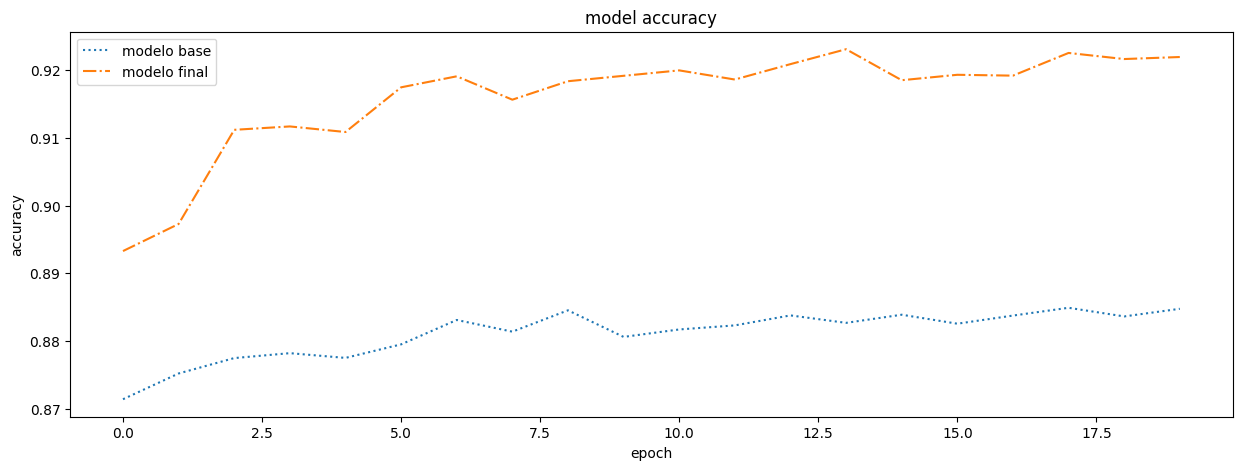

In [ ]:
names = ["modelo base","modelo final"]
avalia_calibracao(names)

A partir do gráfico acima, infere-se que o modelo final apresenta um desempenho superior considerável em relação ao modelo base.

Ainda será feita outra comparação a partir da função run_test:

> 87.792
> 89.883
> 90.467
> 91.767
> 91.825


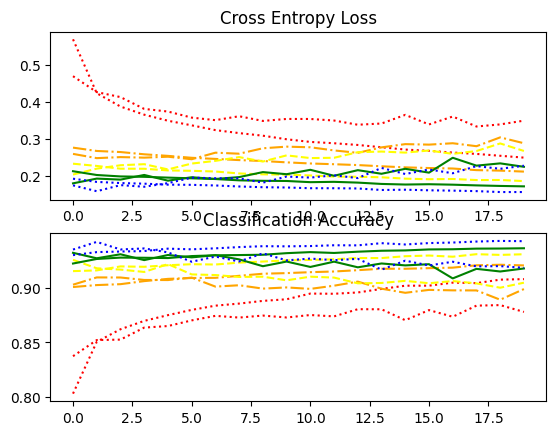

Accuracy: mean=90.347 std=1.480, n=5


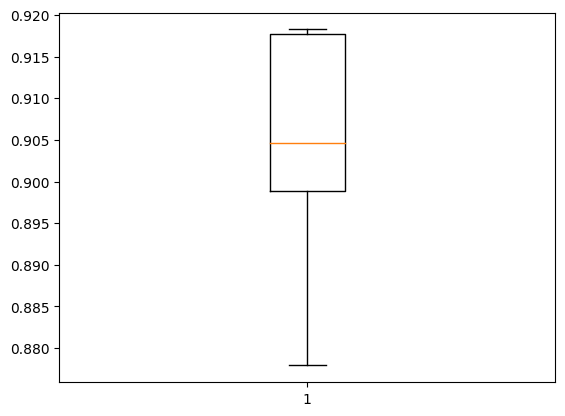

In [ ]:
run_test(define_basic_model())

> 89.808
> 92.392
> 93.450
> 94.758
> 94.967


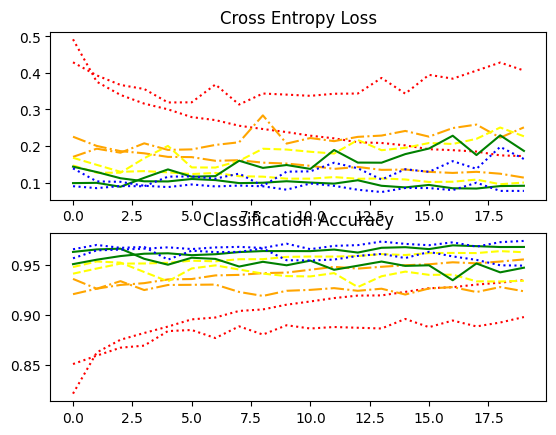

Accuracy: mean=93.075 std=1.881, n=5


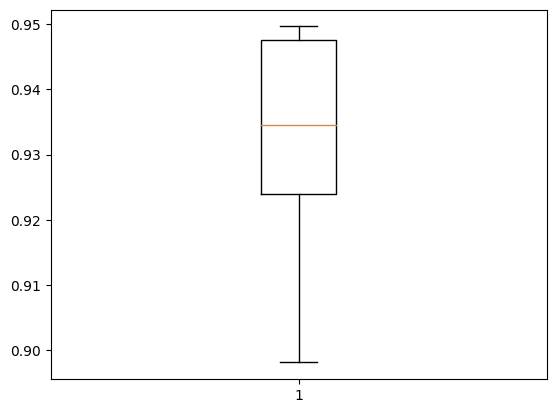

In [ ]:
run_test(define_final_model())

Os gráficos acima permitem inferir que o modelo final possui um desempenho significativamente superior em relação ao modelo base.

Portanto, conclui-se que o modelo final possui um desempenho superior em relação ao modelo base. Sendo assim, ele será utilizado para fazer a predição dos dados de teste.

# Predição

In [ ]:
# Treinando melhor a configuração final
epochs = 30
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x+epochs))

# aplicando fit na configuracao do modelo final
model[1].fit(x_train, y_train, batch_size=64, epochs = 35, callbacks=[annealer], steps_per_epoch = x_train.shape[0]//64, verbose=2)

results = model[1].predict(x_test) # predicao
results = np.argmax(results,axis = 1)
results

Epoch 1/35
937/937 - 3s - loss: 0.1887 - accuracy: 0.9462 - lr: 2.1464e-04 - 3s/epoch - 4ms/step
Epoch 2/35
937/937 - 3s - loss: 0.1258 - accuracy: 0.9606 - lr: 2.0391e-04 - 3s/epoch - 3ms/step
Epoch 3/35
937/937 - 3s - loss: 0.1026 - accuracy: 0.9665 - lr: 1.9371e-04 - 3s/epoch - 3ms/step
Epoch 4/35
937/937 - 3s - loss: 0.0868 - accuracy: 0.9709 - lr: 1.8403e-04 - 3s/epoch - 3ms/step
Epoch 5/35
937/937 - 3s - loss: 0.0732 - accuracy: 0.9752 - lr: 1.7482e-04 - 3s/epoch - 3ms/step
Epoch 6/35
937/937 - 3s - loss: 0.0618 - accuracy: 0.9796 - lr: 1.6608e-04 - 3s/epoch - 3ms/step
Epoch 7/35
937/937 - 3s - loss: 0.0535 - accuracy: 0.9816 - lr: 1.5778e-04 - 3s/epoch - 3ms/step
Epoch 8/35
937/937 - 3s - loss: 0.0452 - accuracy: 0.9848 - lr: 1.4989e-04 - 3s/epoch - 3ms/step
Epoch 9/35
937/937 - 3s - loss: 0.0380 - accuracy: 0.9878 - lr: 1.4240e-04 - 3s/epoch - 3ms/step
Epoch 10/35
937/937 - 3s - loss: 0.0326 - accuracy: 0.9896 - lr: 1.3528e-04 - 3s/epoch - 3ms/step
Epoch 11/35
937/937 - 3s - lo

array([0, 1, 2, ..., 8, 8, 1])

## Acurácia

In [ ]:
y_test = np.argmax(y_test,axis = 1)

In [ ]:
acc = accuracy_score(y_test, results)
print(f'Acurácia = {round(acc, 2) * 100}%')

Acurácia = 91.0%


Observa-se que a acurácia nos dados de teste obtida foi de 91%.

# Dificuldades encontradas

- Entender se a ineficária da aplicação da técnica conhecida como Regularização é possível (a expectativa era de que a aplicação do Regularização L2 iria melhorar o desempenho)
- Entender se a ineficácia de qualquer porcentagem maior que 0 de Dropout é possível (a expectativa era de que a aplicação do Dropout iria melhorar o desempenho)
- Entender se a ineficácia da aplicação da técnica conhecida como Data Augmentation é possível (a expectativa era de que a aplicação do Data Augmentation iria melhorar o desempenho)